In [1]:
 
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#
#  Authored by:    Tommi Heikkilä (LUT)
#                  Margaret Duff (STFC-UKRI)


In [2]:

import cil
print(f"Using CIL version {cil.__version__}")

Using CIL version 24.2.0


# Controlled Wavelet Sparsity using callbacks (3D data)

This notebook showcases an automated method for tuning the regularization parameter towards a good value during the optimization process. It is organized as follows.

1. Set up [the data](#3d-laboratory-micro-ct-fan-beam-data-of-a-seashell) and the appropriate [geometry](#create-geometry). The projection images need to be converted to sinogram.
2. Brief introduction to a representation system called wavelets and explaining what [wavelet regularization](#wavelet-based-regularization) should do.
    - [Traditional run](#fast-iterative-soft-thresholding-algorithm-fista) with fixed regularization parameter using FISTA 
3. Brief explanation of the [controlled wavelet sparsity method](#automated-controlled-sparsity) including the original source and how the CIL implementation is done.
4. Some comments on the [limitations](#limitations-of-the-method) of the method

### 3D laboratory micro-CT, fan-beam data of a seashell

This example uses the seashell dataset `20211124_seashell.zip` from https://doi.org/10.5281/zenodo.6983008 :

- https://zenodo.org/records/6983008/files/20211124_seashell.zip?download=1

If running locally please download the data, unzip the folder and update the 'path' variable below.


In [3]:
path = './data'

In [4]:
# remove some annoying warnings
import logging
logger = logging.getLogger('dxchange')
logger.setLevel(logging.ERROR)

First import all of the modules we will need:

In [5]:
import os
import numpy as np

# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.optimisation.functions import LeastSquares, L1Sparsity, ScaledFunction
from cil.optimisation.operators import WaveletOperator
from cil.optimisation.algorithms import FISTA

from cil.plugins.astra import ProjectionOperator

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import TIFFStackReader

import scipy.io

Load the seashell projections images (TIFFs). There are 721 projections in total, with 0.5 degree interval. We do not need all of them so let's create data with sparser set of projections.

In [6]:
skip = 6
roi = {'axis_0': (0, -1, skip), 'axis_1': -1, 'axis_2': -1}
reader = TIFFStackReader(file_name=path + '/20211124_seashell', transpose=False, roi=roi)
angles = np.linspace(0., 360., 720//skip, endpoint=False)

## Create geometry

We have to manually set the values for the correct geometry. These can be found in the documentation of the data: `20211124_seashell_.txt`.

In [7]:
# Acquisition geometry parameters
SOD = 210.66 # Source-Origin-distance
print(f'SOD: {SOD:.3f} mm')
SDD = 553.74 # Source-Detector-distance
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = 0.05
print(f'Detector pixel size: {pixelSize:.3f} mm')

num_pixels = (2240, 2368) # Projection image width and height

SOD: 210.660 mm
SDD: 553.740 mm
ODD: 343.080 mm
Detector pixel size: 0.050 mm


In [8]:
ag_big = AcquisitionGeometry.create_Cone3D([0,-SOD, 0], [0,ODD, 0], units='mm', detector_direction_x=[1, 0, 0], rotation_axis_direction=[0, 0, -1])
ag_big.set_panel(num_pixels, pixel_size=(pixelSize, pixelSize), origin='bottom-left')
ag_big.set_angles(angles)
ag_big.set_labels(('angle', 'vertical', 'horizontal'))
print(ag_big)

3D Cone-beam tomography
System configuration:
	Source position: [   0.  , -210.66,    0.  ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [  0.  , 343.08,   0.  ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [2240 2368]
	Pixel size: [0.05 0.05]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 120
	Angles 0-9 in degrees: [ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27.]
	Angles 110-119 in degrees: [330., 333., 336., 339., 342., 345., 348., 351., 354., 357.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


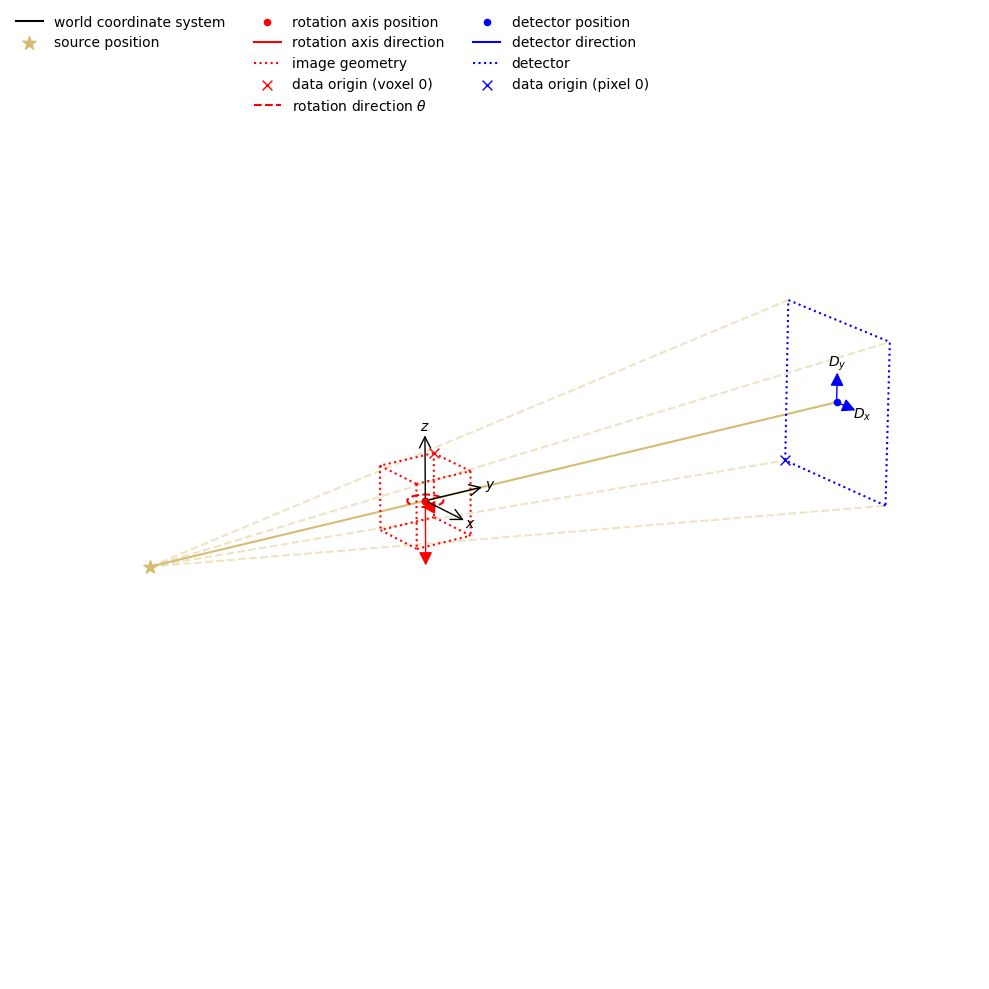

In [9]:
show_geometry(ag_big);

### Read data and add geometry

In [10]:
big_raw_data = reader.read_as_AcquisitionData(ag_big)

Number of dimensions: 3
Shape: (120, 2368, 2240)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



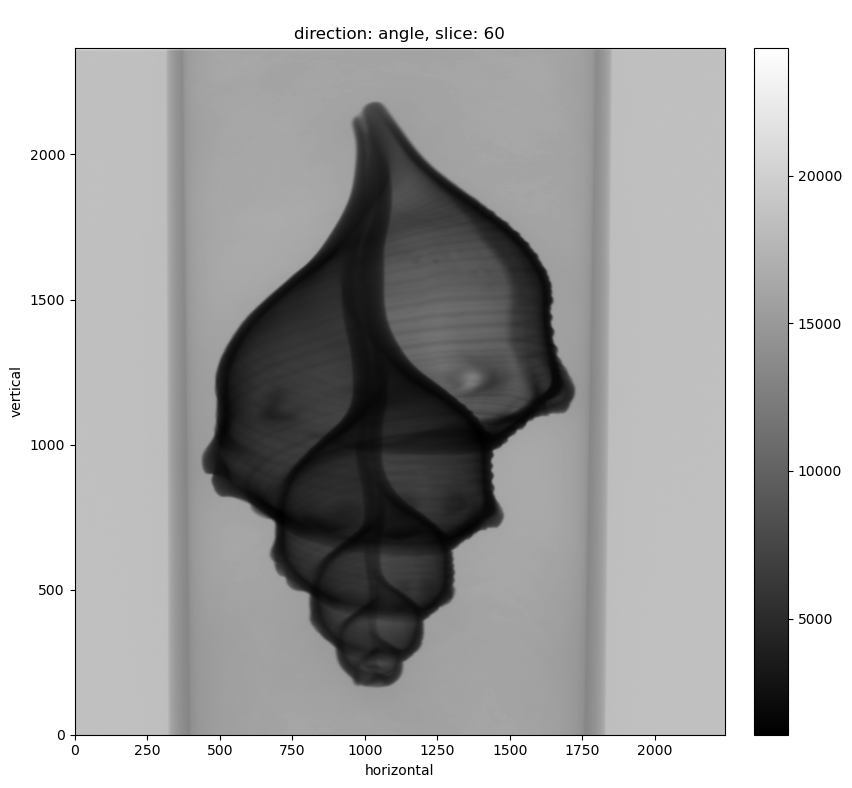

In [11]:
print(big_raw_data)
show2D(big_raw_data);

### Process the data
We want to bin the data to smaller resolution and convert from transmission to absorption images

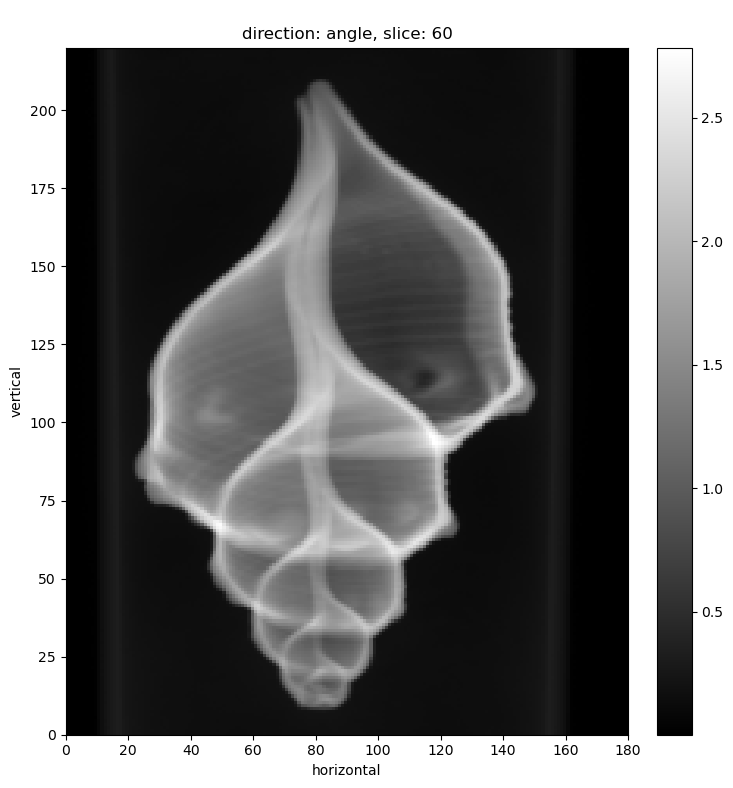

Number of dimensions: 3
Shape: (120, 220, 180)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [12]:
from cil.processors import Binner, TransmissionAbsorptionConverter


binning = 10
binner_processor = Binner(roi={'horizontal': (220, 2020, binning), 'vertical': (84, 2284, binning)})
binner_processor.set_input(big_raw_data)
raw_data = binner_processor.get_output()

# Get the raw intensity from the mean of the k largest values
k = 100
max_k = np.partition(raw_data.as_array(), -k, axis=None)[-k:].mean()
transmission_processor = TransmissionAbsorptionConverter(white_level=max_k)
transmission_processor.set_input(raw_data)
data = transmission_processor.get_output()

show2D(data)
print(data)

### Image geometry and data

In [13]:
# Setup image geometry
(_, nz, nx) = data.shape
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x180,y180,z220
voxel_size : x0.1902156246613934,y0.1902156246613934,z0.1902156246613934
center : x0,y0,z0



## Reconstructions

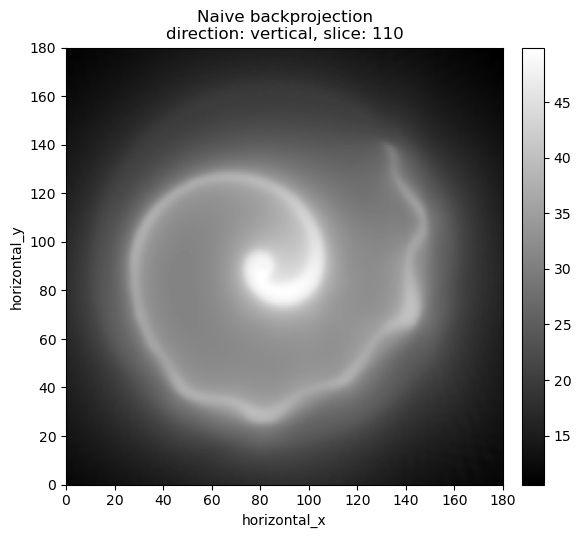

In [14]:
data.reorder('astra')
ag = data.geometry
A = ProjectionOperator(ig, ag, 'gpu')

x_bp = A.adjoint(data) # Simple backprojection
show2D(x_bp, size=(10,10), title="Naive backprojection");

In [15]:
islicer(x_bp)

# Wavelet based regularization

Classical approach in imaging problems (such as CT, denoising, etc.) is to try represent the key information about the solution using a wavelet basis. By construction a relatively sparse solution (i.e. only few nonzero components) should suffice, as opposed to pixel-based representation.

In short, we have the least squares data mismatch term of form
$$ \frac{1}{2} \| A x - m_\delta \|_2^2,$$
where $A$ is the forward operator, $m_\delta$ is the noisy data and $x$ is the unknown solution. 
Then we add a regularization term of the form
$$ \alpha \| W(x) \|_1 = \alpha \sum_{j,k} | c(x)_{j,k} |, $$
where $\alpha > 0$ is the regularization term (balacing our trust in data and need in regularization) 
and $W$ is the Discrete Wavelet Transform operator which decomposes any input $x$ (signal, image or volume) into a sequence of coefficients $c(x)_{j,k}$ of varying scale ($j \in \mathbb{N}$) and location ($k \in \mathbb{Z}^d$), such that
$$ x = \sum_{j,k} c(x)_{j,k} \psi_{j,k}.$$

### Wavelet transform

Classical choice is one of the orthogonal wavelets of [Ingrid Daubechies](https://en.wikipedia.org/wiki/Ingrid_Daubechies), usually distinguished by their smoothness properties. For example the Daubechies-2 wavelets always give continuous approximations.

In [16]:
wname = 'db2'
level = 4

W = WaveletOperator(ig, level=level, wname=wname)

### Fast Iterative Soft Thresholding Algorithm (FISTA)
Equally classic choice of minimization algrorithm in the (Fast) Iterative Soft Thresholding Algorithm (ISTA), originally developed for wavelet-based denoising in  
> Daubechies, I, Defrise, M, & De Mol, C..  
*An iterative thresholding algorithm for linear inverse problems with a sparsity constraint.*  
Communications on Pure and Applied Mathematics: A Journal Issued by the Courant Institute of Mathematical Sciences 57.11 (2004): 1413-1457.

Although we will run the accelerated version.

In [17]:
f = LeastSquares(A, data)
g = L1Sparsity(W)

tau = 1e-5  # Regularization parameter

fista = FISTA(initial=ig.allocate(0), f=f, g=tau*g)

Let's run arbitrary number of iterations (200)

In [18]:
fista.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

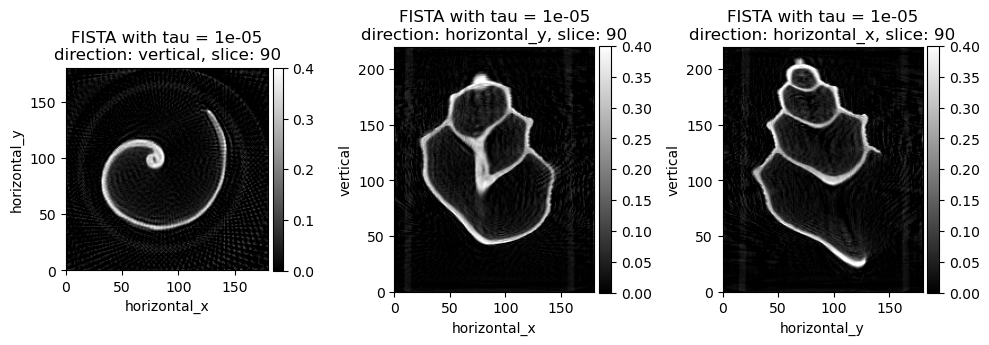

In [19]:
x_fista = fista.get_output()
show2D(x_fista, size=(10,10), fix_range=(0,0.4), title=f"FISTA with {tau = }", num_cols=3, slice_list=[(0, 90), (1, 90), (2, 90)]);

In [27]:
islicer(x_fista, minmax=(0,0.4), title=f"FISTA with {tau = },")

Looks okay but how do we know the choice of regularization parameter was good? Could we get a better result with another value? Do we have the patience to try out dozens or even hundreds of values?

## Automated Controlled Sparsity

We follow the automated tuning strategy as introduced in  
> Purisha, Z., Rimpeläinen, J., Bubba, T., & Siltanen, S. (2017).  
*Controlled wavelet domain sparsity for x-ray tomography*.  
Measurement Science and Technology, 29(1), 014002.  
[DOI:10.1088/1361-6501/aa9260](https://doi.org/10.1088/1361-6501/aa9260)

We'll try to implement it as a `StepSizeRule` and `callback`. However we are NOT actually changing the `step_size` (which is based on the Lipschitz constant of the data mistmatch term) but the regularization parameter `tau`. However, we can update it every iterate by using `StepSizeRule` (in fact we could pass it an actual `StepSizeRule` to perform but let's just stick with constant value for now).

In [20]:
from SparsityControl import ControlledSparsity, DesiredSparsity

In [21]:
reg_weight = 1e-2
# Automated tuning of regularization parameter, smaller step_weight makes the tuning slightly slower -> not as severe overshoot in reg. param. value
sparsity_ctrl = ControlledSparsity(desired_sparsity=0.3, step_weight=0.1)
fista_controlled = FISTA(initial=ig.allocate(0), f=f, g=reg_weight*g, step_size=sparsity_ctrl, max_iteration=500)

In [22]:
# Sparsity based stopping rule
sparsity_stop = DesiredSparsity(print_stuff=2, rel_change_tol=5e-4)

In [23]:
fista_controlled.run(500, callbacks=[sparsity_stop])

Iteration : 5 | Current sparsity: 0.751 | Regularization param.: 1.02e-02 | Desired sparsity: 0.300 | Difference: 0.451 | Beta: 2.55e-04 | Relative change: 1.27e-01
Iteration : 10 | Current sparsity: 0.747 | Regularization param.: 1.07e-02 | Desired sparsity: 0.300 | Difference: 0.447 | Beta: 2.55e-04 | Relative change: 6.41e-02
Iteration : 15 | Current sparsity: 0.739 | Regularization param.: 1.13e-02 | Desired sparsity: 0.300 | Difference: 0.439 | Beta: 2.55e-04 | Relative change: 3.75e-02
Iteration : 20 | Current sparsity: 0.731 | Regularization param.: 1.18e-02 | Desired sparsity: 0.300 | Difference: 0.431 | Beta: 2.55e-04 | Relative change: 2.38e-02
Iteration : 25 | Current sparsity: 0.722 | Regularization param.: 1.24e-02 | Desired sparsity: 0.300 | Difference: 0.422 | Beta: 2.55e-04 | Relative change: 1.58e-02
Iteration : 30 | Current sparsity: 0.713 | Regularization param.: 1.29e-02 | Desired sparsity: 0.300 | Difference: 0.413 | Beta: 2.55e-04 | Relative change: 1.09e-02
Itera

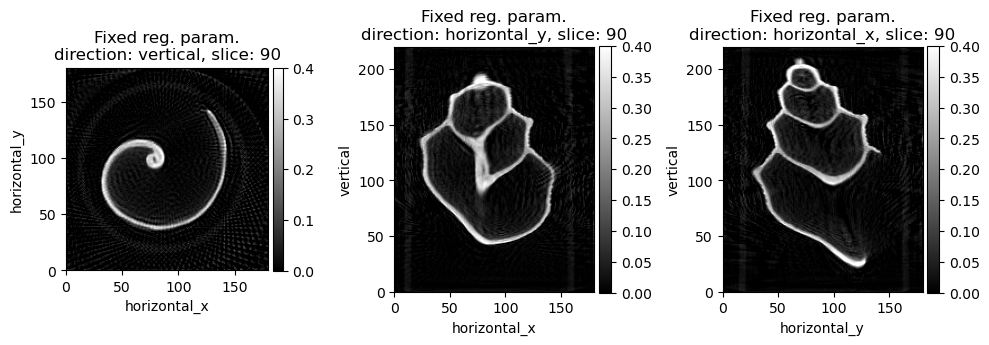

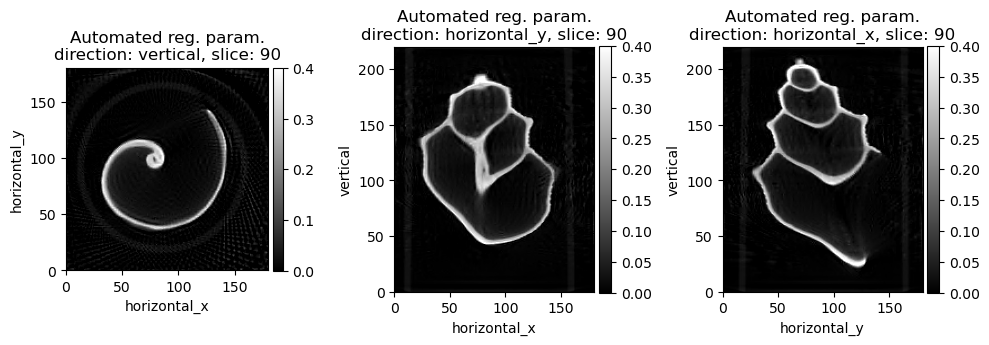

In [24]:
x_controlled = fista_controlled.solution
show2D(x_fista, title="Fixed reg. param.", fix_range=(0,0.4), size=(10,20), num_cols=3, slice_list=[(0, 90), (1, 90), (2, 90)]);
show2D(x_controlled, title="Automated reg. param.", fix_range=(0,0.4), size=(10,20), num_cols=3, slice_list=[(0, 90), (1, 90), (2, 90)]);

We can use islicer to view the automated controlled solution: 

In [25]:
islicer(x_controlled, minmax=(0,0.4), title=f"Automated parameter choice")

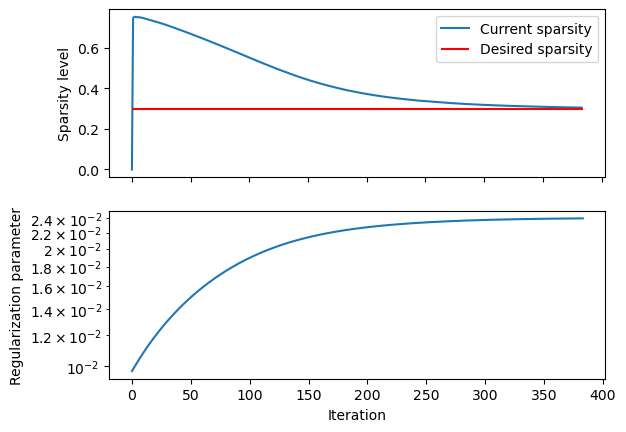

In [26]:
import matplotlib.pyplot as plt

N = fista_controlled.iterations[-1]
fig, ax = plt.subplots(2)
ax[0].plot(sparsity_ctrl.sparsity_vals, label='Current sparsity')
ax[0].hlines(sparsity_ctrl.desired_sparsity, xmin=0, xmax=N, colors='r', label='Desired sparsity')
ax[0].set_ylabel("Sparsity level")
ax[0].legend()

ax[1].semilogy(sparsity_ctrl.reg_param_vals)
ax[1].set_ylabel("Regularization parameter")
ax[1].set_xlabel("Iteration")
for a in ax.flat:
    a.label_outer()

Here we can see how increasing the regularization parameter (lower plot) drives the sparsity level down towards the desired level (top plot). The iteration can be stopped once the suitable level has been reached (and the relative change is small enough).

Notice also how the tuning is adaptive, in the sense that as we get closer to the desired sparsity level, the incremental changes in the regularization parameter get finer.

### Limitations of the method

The method does not fully automate the choice of regularization parameter as the desired sparsity level and some of the tuning parameters still need to be chosen. 
However, chosing a good level of sparsity is much easier, the values are clearly bounded between 0 and 1 (corresponding to 0% and 100% of coefficients being "meaningful") and the tuning parameters mostly affect the speed on the method. 
Moreover, with bit of experience, it is relatively easy to tell early whether the choice will be good and restart the algorithm if needed.